In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

# Derivative

In [178]:
def f(x):
  return 3 * x**2 - 4*x + 5

In [179]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [180]:
ys = f(xs)

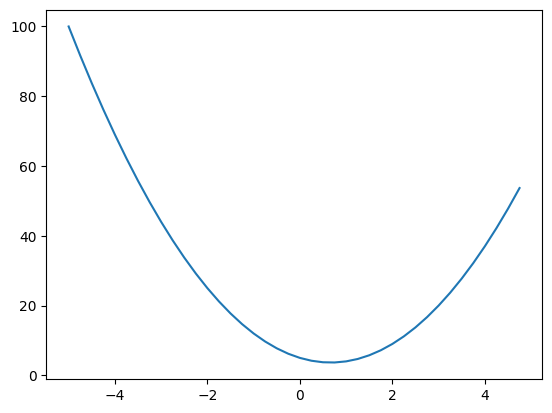

In [181]:
plt.plot(xs,ys)

In [182]:
h = 0.0001
x = 3
(f(x + h) - f(x)) / h

14.000300000063248

In [183]:
a = 2
b = -3
c = 1

d1 = a*b + c

h = 0.0001

c+=h
d2 = a*b + c

(d2 - d1) / h

0.9999999999976694

# Starting the core Value object of micrograd and its visualization

In [184]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [185]:
a = Value(2.0)
a + 1
a * 2
2 * a

a / 2
a - 2

Value(data=0.0)

In [186]:
a = Value(2.0,  label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e'

d = e + c; d.label = 'd'

f = Value(-2.0, label = 'f')

L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [187]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

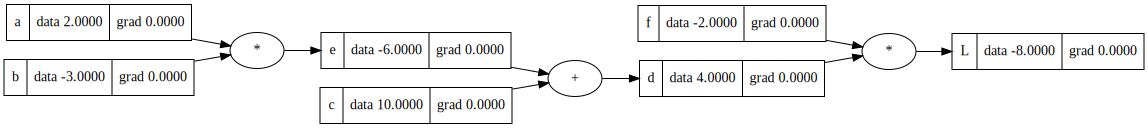

In [188]:
draw_dot(L)

# Manual Backpropogation Example #1 - Simple Expression

In [189]:
def lol():
  a = Value(2.0,  label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')

  e = a * b; e.label = 'e'

  d = e + c; d.label = 'd'

  f = Value(-2.0, label = 'f')

  L1 = d * f; L.label = 'L'

  h = 0.000000001

  a = Value(2.0,  label = 'a')
  b = Value(-3.0 + h, label = 'b')
  c = Value(10.0, label = 'c')

  e = a*b; e.label = 'e'

  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')

  L2 = d * f; L.label = 'L'

  return (L2.data - L1.data) / h

In [190]:
lol()

-4.000000330961484

In [191]:
L.grad = 1.0
f.grad = 4.0
d.grad = 2.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4.0
a.grad = 6.0

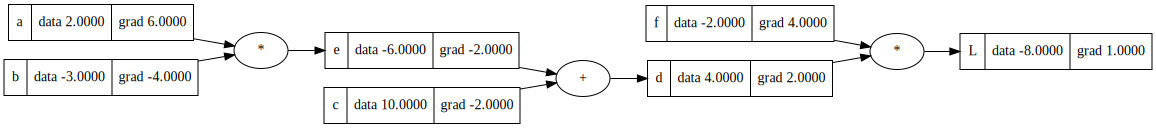

In [192]:
draw_dot(L)

# Preview of a single optimization step

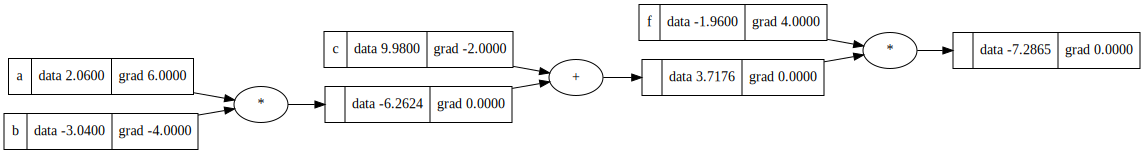

In [193]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b;

d = e + c;

L = d * f;
L

draw_dot(L)

# Manual Backprop through a Neuron

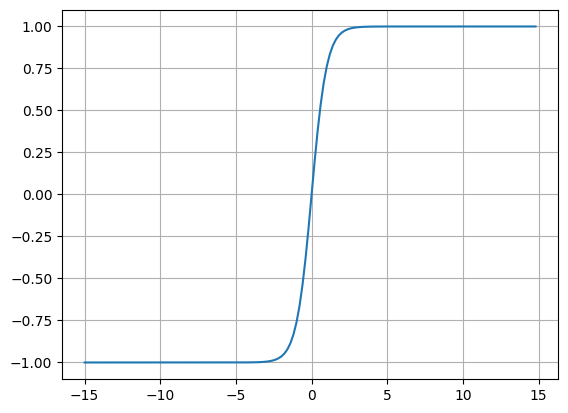

In [194]:
plt.plot(np.arange(-15,15,0.2) , np.tanh(np.arange(-15, 15, 0.2))); plt.grid()

In [195]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


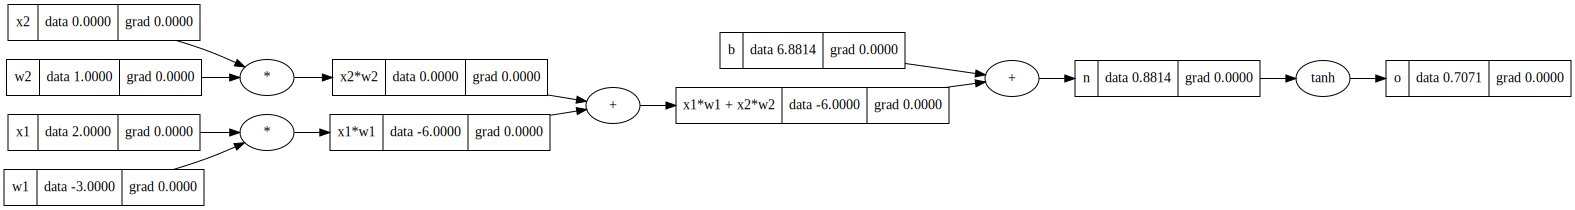

In [196]:
draw_dot(o)

In [197]:
np.tanh(0.8814)

0.7071199874301226

In [198]:
o.grad = 1.0

n.grad = 0.5 # 1 - o**2

b.grad = 0.5
x1w1x2w2.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x1.grad = 0.5
x2.grad = 0.5
w1.grad = 0.5
w2.grad = 0.5

w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [199]:
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

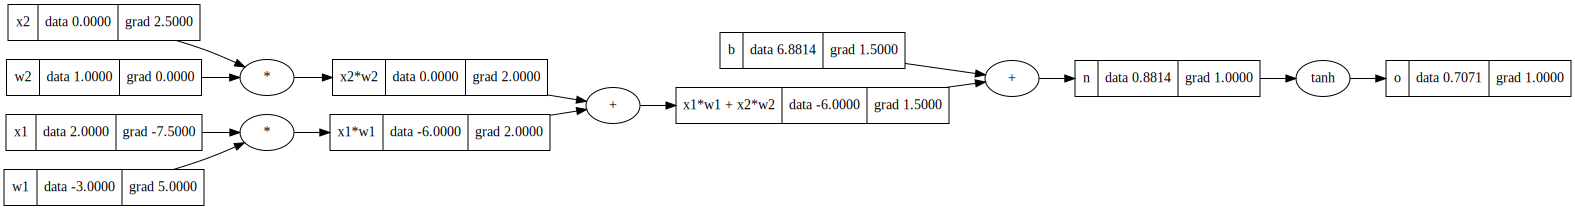

In [200]:
draw_dot(o)

In [201]:
o.grad = 1

topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)

for node in reversed(topo):
  node._backward()

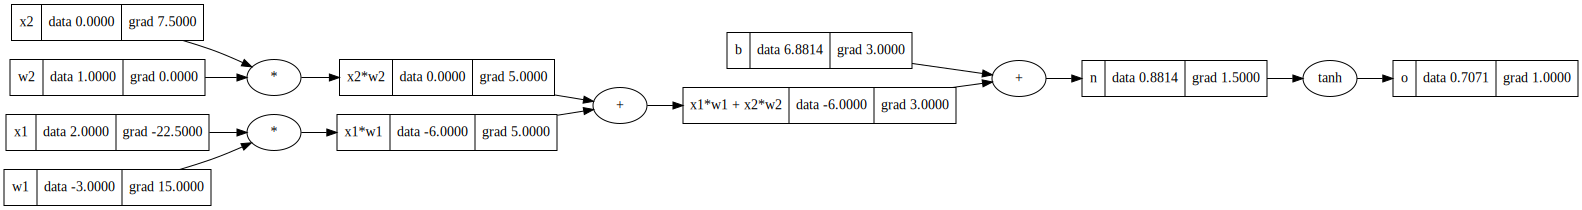

In [202]:
draw_dot(o)

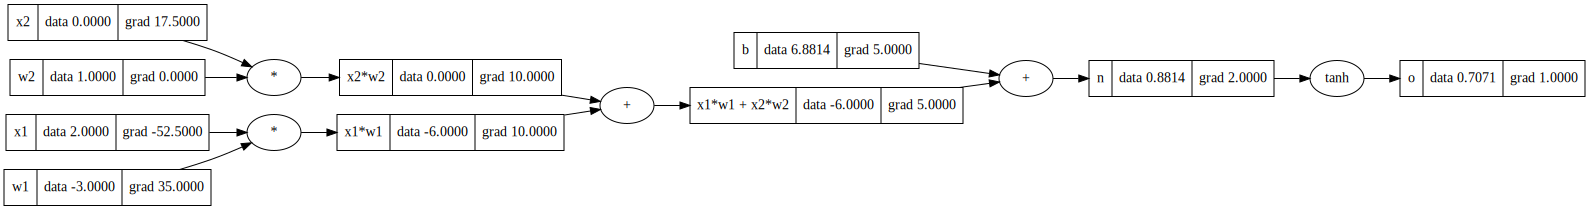

In [203]:
o.backward()

draw_dot(o)

In [204]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b

Value(data=6.0)

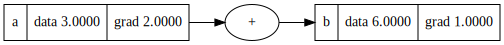

In [205]:
b.backward()
draw_dot(b)

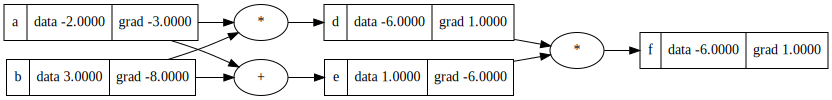

In [206]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

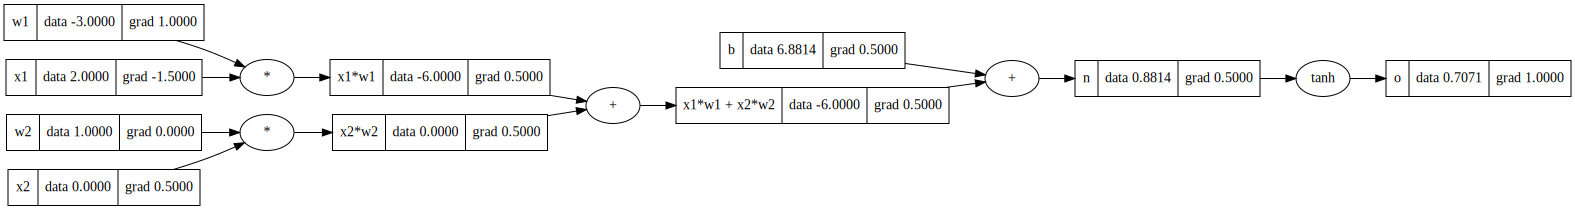

In [207]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

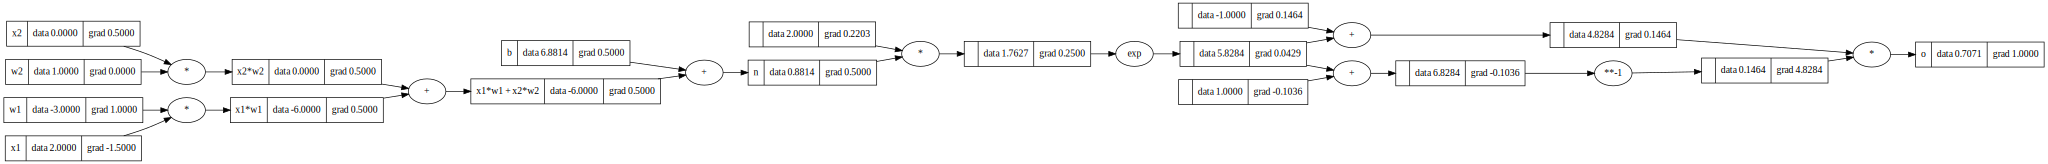

In [208]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [209]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [210]:
import random

In [211]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi * xi for wi , xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [212]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4 , 4 , 1])
n(x)

Value(data=-0.5923547128173232)

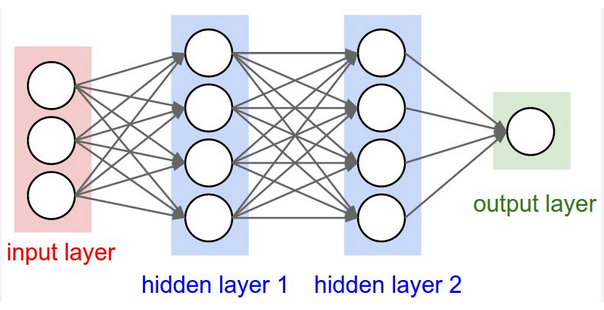

In [213]:
len(n.parameters())

41

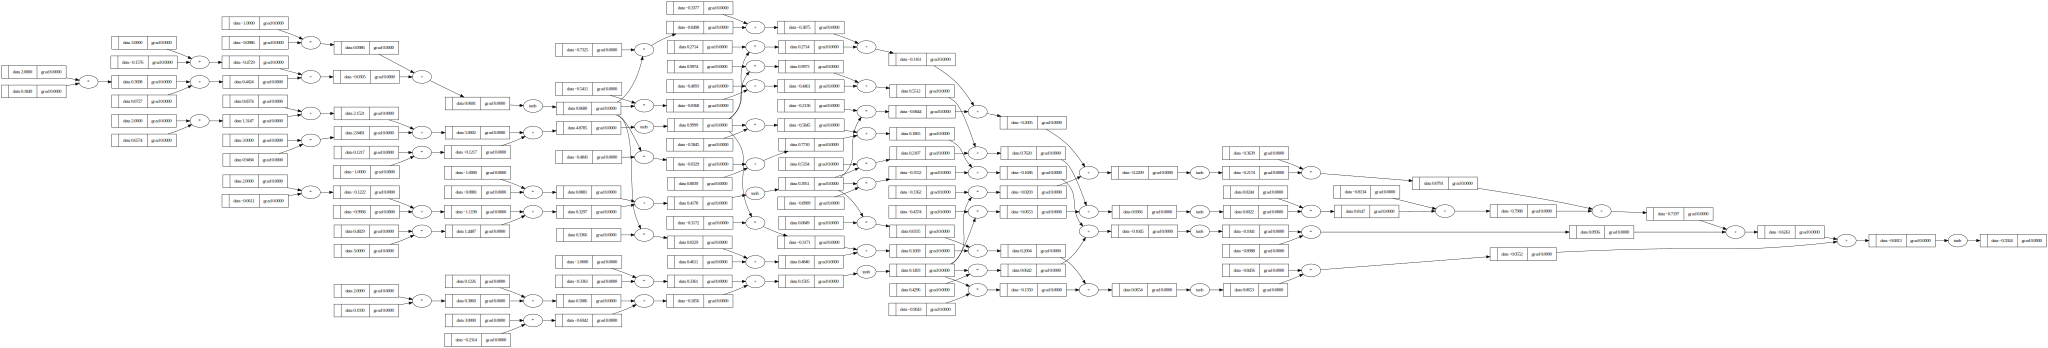

In [214]:
draw_dot(n(x))

In [215]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [216]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5923547128173232),
 Value(data=-0.8159654976150628),
 Value(data=-0.9314636716024233),
 Value(data=-0.8172114133704473)]

In [225]:
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss

Value(data=5.876416778693651)

In [226]:
loss.backward()

In [223]:
n.layers[0].neurons[0].w[0].grad

-1.867226209593769

In [224]:
n.layers[0].neurons[0].w[0].data

0.2035541735860758

In [222]:
### Gradient Descent
alpha = 0.01
for p in n.parameters():
  p.data += -alpha * p.grad

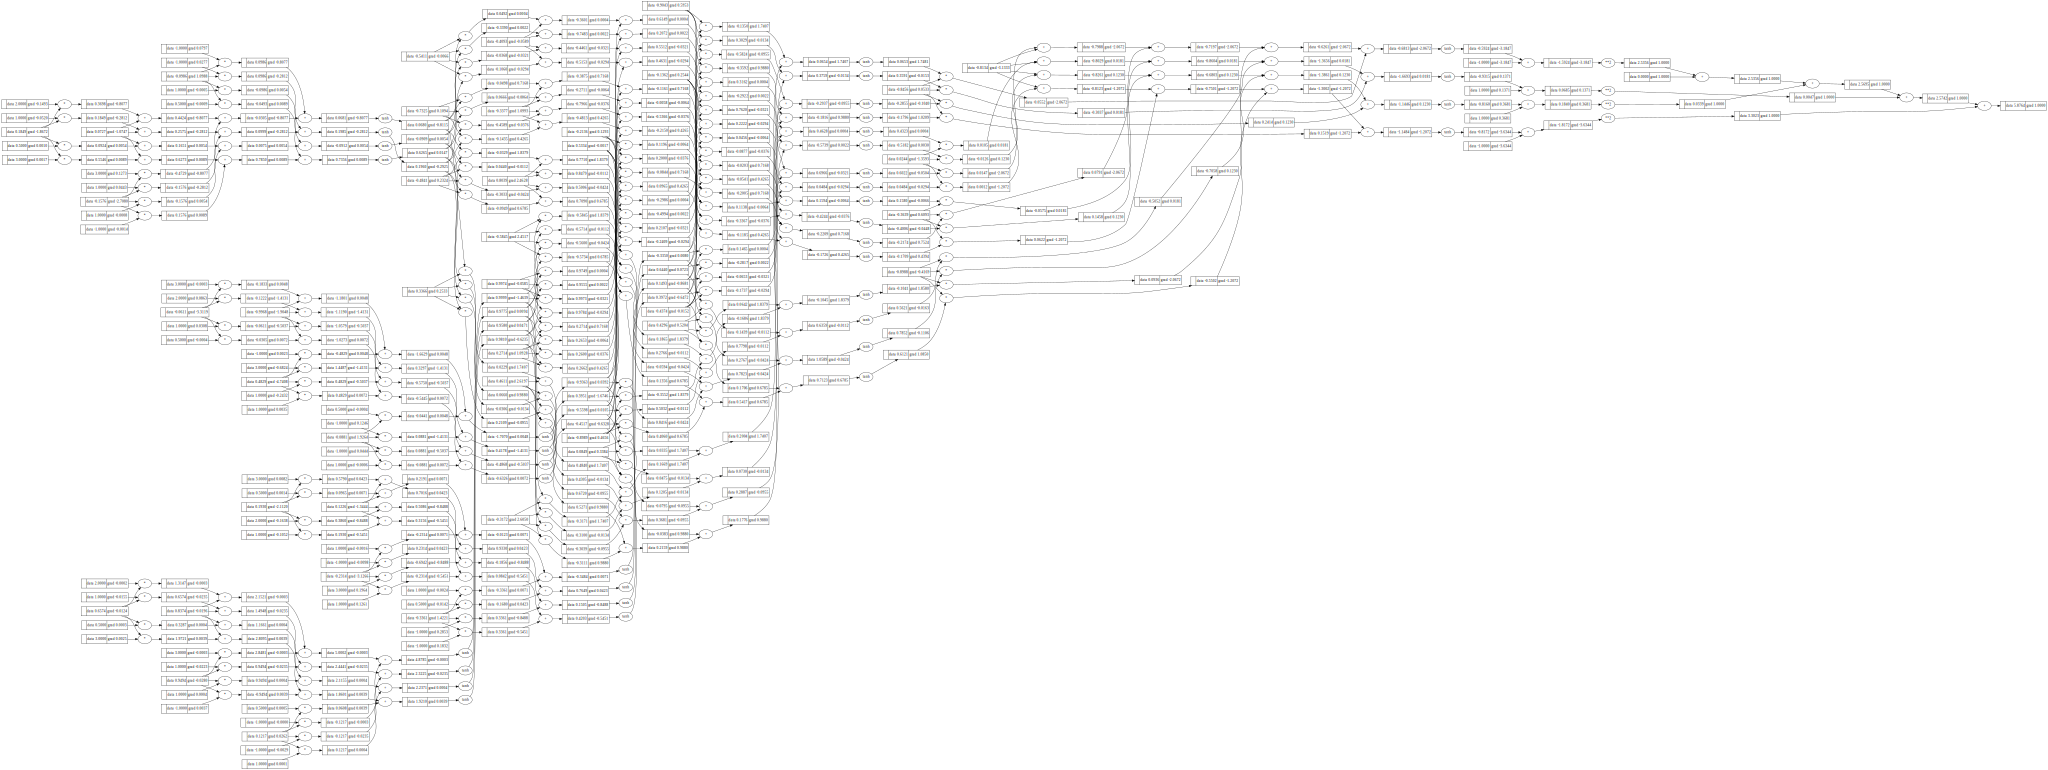

In [220]:
draw_dot(loss)

In [227]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4 , 4 , 1])
n(x)

Value(data=0.20908923781559346)

In [228]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [233]:
alpha = 0.05

for k in range(100):

  ## Forward Pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

  ## Update Grads to 0
  for p in n.parameters():
    p.grad = 0.0

  ## Backward Pass
  loss.backward()

  ## Gradient Descent(update weights)
  for p in n.parameters():
    p.data += -alpha * p.grad


In [234]:
ypred

[Value(data=0.9754228019825083),
 Value(data=-0.9735579589946765),
 Value(data=-0.9564431859981514),
 Value(data=0.963759928757068)]